# Ensemble learning

In [36]:
from typing import List, Type, Union

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import fetch_openml
from sklearn.base import ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier

## Zbiór danych

W zadaniu poddany analizie będzie dobrze już znany zbiór MNIST.

In [2]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

In [3]:
X = mnist.data[:10000]
y = mnist.target[:10000]

## Transformacja zbioru do przestrzeni 30D

In [4]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

pca = PCA(30)
X_pca = pca.fit_transform(X_scaled)

## Wybór trudno rozdzielalnych cech

W celu znalezienia trudno rozróżnialnych cech zbioru możemy skorzystać z metody t-SNE.

In [5]:
X_embedded = TSNE(n_components=2).fit_transform(X_pca)
X_embedded.shape

(10000, 2)

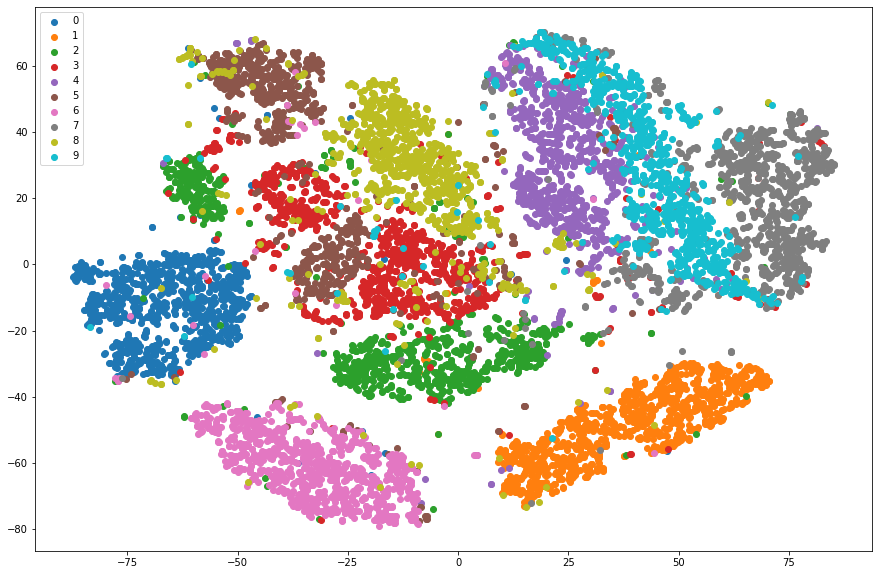

In [29]:
ids = [str(i) for i in range(10)]
plt.figure(figsize=(15, 10))

for c, label in zip(mcolors.TABLEAU_COLORS, ids):
    plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1], c=c, label=label)
plt.legend()
plt.show()

Wyraźnie widać zgrupowanie klasy 4 i 9. Użyjemy ich w dalszej części zadania.

In [7]:
digit_filter = np.where((y == '4') | (y == '9'))
X_filtered, y_filtered = X_pca[digit_filter], y[digit_filter]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=13)

In [9]:
X_train.shape

(1566, 30)

## Bagging

W zależności od sposobu wyboru podzbiorów zbioru danych wyróżniamy różne rodzaje tego algorytmu:

- **pasting** - wybór losowych podzbiorów próbek
- **bagging** - wybór losowych podzbiorów próbek ze zwracaniem
- **random subspaces** - wybór losowych podzbiorów cech
- **random patches** - wybór losowych podzbiorów próbek i cech

W praktyce wybór metody sprowadza się do odpowiedniego ustawienia zmiennych w klasyfikatorze BaggingClassifier.
Szczegółowy opis można znaleźć w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) sklearn.

#### Klasyczny bagging

Jak zostało wyżej wspomniane - w tej metodzie wybieramy losowo podzbory próbek ze zwracaniem. Jest to domyślny wariant klasyfikatora BaggingClassifier.

In [10]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        max_samples=0.5).fit(X_train, y_train)

In [11]:
clf.score(X_test, y_test)

0.9719387755102041

Metody grupowania są silnie uzależnione od ilości klasyfikatorów oraz ilości próbek, których użyjemy do ich trenowania. Możemy w prosty sposób zwizualizować tą zależność:

In [123]:
def ensemble_scores(clf, estimators, samples, base_estimator=None):
    for n_estimators in estimators:
        for max_samples in samples:
            fitted_clf = clf(base_estimator=base_estimator,
                             n_estimators=n_estimators,
                             max_samples=max_samples).fit(X_train, y_train)
            yield n_estimators, max_samples, fitted_clf.score(X_test, y_test)

            
def visualize_ensemble(clf, n_estimators, max_samples, base_estimator=None):
    values = np.array(list(ensemble_scores(clf, n_estimators, max_samples, base_estimator)))
    X = values[:,0]
    Y = values[:,1]
    Z = values[:,2]
    
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection='3d')
    ax.plot_trisurf(X, Y, Z, linewidth=0, antialiased=True, cmap='viridis')

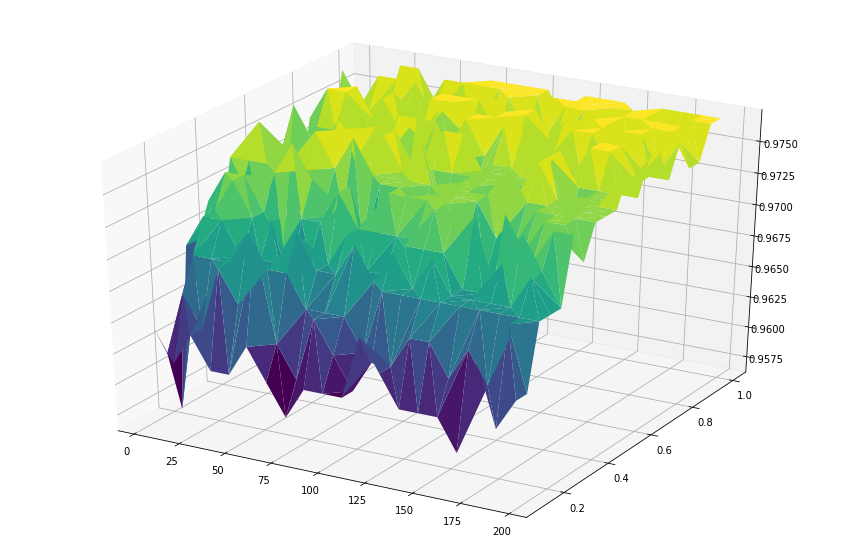

In [126]:
estimators = np.arange(5, 200, 10)
samples = np.linspace(0.1, 1., num=20)

visualize_ensemble(BaggingClassifier, estimators, samples, base_estimator=SVC())

#### Random subspace

Metoda random subspace od zwykłego baggingu różni się tym, że wybieramy podzbiory cech zamiast podzbiorów próbek. Ustawiamy flagi:
- **bootstrap_features=True** - wybieramy cechy ze zwracaniem
- **max_samples=1.0 (default)** - nie losujemy próbek (bierzemy wszystkie)
- **max_features=n** - ilość losowanych cech

In [132]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        bootstrap_features=True,
                        max_features=0.5).fit(X_train, y_train)

In [133]:
clf.score(X_test, y_test)

0.9566326530612245

#### Random patching

Połączenie powyższych metod nazywamy _random patching_. Ze zbioru losujemy i próbki, i cechy.

In [127]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        bootstrap_features=True,
                        max_features=0.5,
                        max_samples=0.6).fit(X_train, y_train)

In [131]:
clf.score(X_test, y_test)

0.9209183673469388

### Zadanie
1. Zwizualizuj za pomocą tabeli zależność powyższych metod od *n_estimators* i *max_samples*/*max_features*.
2. Odpowiedz na pytanie: jak zmienia się dokładność klasyfikacji dla różnych metod określana finalnej decyzji (normalna średnia, majority vote, etc.)

## Random Forest


Metoda Random Forest różni się od baggingu przede wszystkim tym, że cechy wybierane są losowo spośród wszystkich i najlepszy podział z podzbioru zostaje użyty do dzielenia węzłów w drzewie.
W baggingu natomiast podczas dzielenia węzłów bierze się pod uwagę wszystkie cechy.

Szczegółowy opis znajduje się w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) sklearn.

In [14]:
clf = RandomForestClassifier(n_estimators=5,
                             max_samples=0.5).fit(X_train, y_train)

In [15]:
clf.score(X_test, y_test)

0.9209183673469388

## Ada Boost

Metoda, która agreguje wiele słabszych klasyfikatorów w jeden większy. W odróżnieniu od baggingu waga drzew nie jest jednakowa.

Szczegółowy opis znajduje się w [dokumentacji](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html?highlight=adaboost#sklearn.ensemble.AdaBoostClassifier) sklearn.

In [16]:
clf = AdaBoostClassifier(n_estimators=5).fit(X_train, y_train)

In [17]:
clf.score(X_test, y_test)

0.8163265306122449

## Projekt indywidualny


Dokonaj analizy zbioru danych FMNIST za pomocą wyżej wymienionych klasyfikatorów.

In [18]:
fmnist = fetch_openml("Fashion-MNIST", data_home="./fmnist", cache=True)

1. Ze zbioru wybierz dwie trudno rozdzielalne cechy i wykorzystaj je do dalszej analizy.
2. Sprawdź wydajność klasyfikatorów Bagging, RandomForest i AdaBoost dla powstałego zbioru.
3. Dla każdego zbioru sprawdź zależność wyniku od ilości klasyfikatorów bazowych. Zaprezentuj wyniki w tabelce. 